!export FLASK_APP=Class6_model_api.py
!flask run --host=0.0.0.0 --port=5001

# 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import pickle
from flask import Flask, request, jsonify
import threading
import requests


# 2. Load and Explore Dataset

In [2]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')

print("Dataset Shape:", X.shape)
print("Feature Names:", iris.feature_names)
X.head()


Dataset Shape: (150, 4)
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# 3. Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

# -----------------------------------------

Training samples: 105
Test samples: 45


# 4. Model Training & Hyperparameter Tuning

In [4]:
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 8, None],
    'min_samples_split': [2, 4, 6]
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

best_model = grid.best_estimator_


Best Parameters: {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100}
Best CV Accuracy: 0.9619047619047618


# 5. Evaluate the Best Model

In [5]:
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 0.9111111111111111

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.88        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



# 6. Serialize (Save) the Model to Pickle

In [6]:
pickle_filename = "best_random_forest_model.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"✅ Model saved to {pickle_filename}")

✅ Model saved to best_random_forest_model.pkl


# 7. Serve the Model via Flask API

>>> Use Script (Class6_model_api.py)

# 8. Run Flask in Background (for Demo)

In [7]:
from flask import Flask
app = Flask(__name__)

def run_flask():
    app.run(port=5002, debug=True)

thread = threading.Thread(target=run_flask)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


Address already in use
Port 5002 is in use by another program. Either identify and stop that program, or start the server with a different port.


# 9. Test the API Request (Demo)

In [8]:
import time
time.sleep(2)  # Wait for Flask to start

sample = X_test.iloc[0].tolist()
response = requests.post("http://127.0.0.1:5002/predict", json={"features": sample})
print("API Response:", response.json())

API Response: {'prediction': 2}


curl -X POST http://127.0.0.1:5001/predict \
     -H "Content-Type: application/json" \
     -d '{"features": [5.1, 3.5, 1.4, 0.2]}'


# 10. AutoML Example (TPOT)

/Users/barbon/Python/440MI/venv/lib/python3.11/site-packages/tpot2/tpot_estimator/estimator.py:455: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
/Users/barbon/Python/440MI/venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60729 instead
  warnings.warn(
Generation:   0%|          | 0/5 [00:00<?, ?it/s]/Users/barbon/Python/440MI/venv/lib/python3.11/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Generation: 100%|██████████| 5/5 [00:38<0

Test Accuracy: 0.933

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



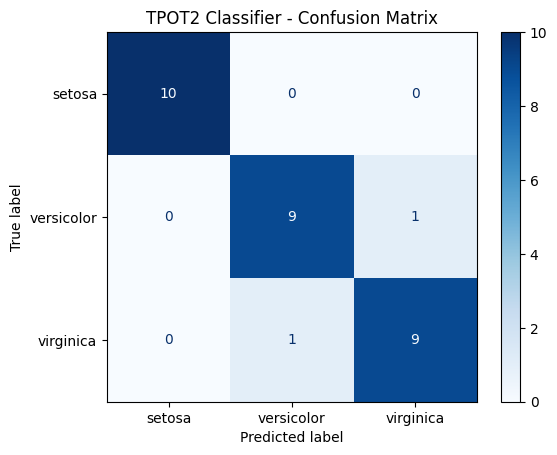


Best Pipeline:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectpercentile',
                 SelectPercentile(percentile=37.1143747020325)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('baggingclassifier',
                 BaggingClassifier(bootstrap=False,
                                   max_features=0.2702125978585,
                                   max_samples=0.2856136930742, n

In [31]:

from tpot2 import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Load the Iris dataset ---
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

# --- Split data into training and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Initialize TPOT2 AutoML classifier ---
tpot = TPOTClassifier(
    generations=5,                # number of generations
    population_size=20,           # number of pipelines per generation
    random_state=42,
    max_time_mins=2,              # search duration
    n_jobs=1,                    # use all cores
)

# --- Fit the TPOT model ---
tpot.fit(X_train, y_train)

# --- Evaluate on test data ---
y_pred = tpot.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))

# --- Visualize confusion matrix ---
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=iris.target_names).plot(cmap="Blues")
plt.title("TPOT2 Classifier - Confusion Matrix")
plt.show()

# --- Access best pipeline ---
best_model = tpot.fitted_pipeline_ 
print("\nBest Pipeline:")
print(best_model)